# Welcome to the Non-Player Walkthrough!

If you're reviewing this notebook, you're most likely just interested in the project from a data/technical perspective. If so, you're in the right place! I'll be providing you an overview of what this project does and demonstrating the functionality of the main class: the `GachaSim`.

## First, some background.

"Gacha" involves spending currency in a game on a chance at getting certain items that you want. This currency can be earned for free in game, purchased with real-world money, or both. Companies are legally **required** to tell you the probability of getting certain items each time you spend currency to get an item (an action often referred to as "pulling"). For example, in Final Fantasy 7 Ever Crisis (EC), with one pull, you have a 7.5% chance of getting a 5* weapon, which is the strongest type of weapon. You have a 22.5% chance of getting a 4* (weaker, almost worthless weapon) and a 70% chance of getting a 3* weapon (absolute trash that you will never use). Within the chance of achieving each rarity level, there are a wide range of weapons that a player can receive. Everything is based on random chance, so sometimes you'll get what you want, and sometimes you won't. 

Sometimes you'll even get a 5*, and it's not a 5* that you particularly wanted. Oh, and here's the kicker -- getting a specific weapon at 5* rarity usually isn't enough. You have to get that same weapon at 5* rarity many, many times in order for it to be as strong as possible. Diabolical, right?

## The Problem

Although companies share the probability of getting the weapons you want, they only do so for a single "pull." Typically, a player will execute tens or even hundreds of pulls in one session, meaning the information provided doesn't completely match the scenario we're interested in. This mismatch can lead to players misinterpreting these rates and spending more than they intend to. This is a big deal, because as I mentioned earlier, players can choose to use **real world money** to get more chances at pulling. Are gambling alarm bells going off in your head right now? Completely justified.

Here are two examples of what players **actually** want to know: 

1. "If I spend `X` amount of currency, how much of weapon `Y` am I likely to get?" (i.e., estimate achieved weapon power with currency held constant)
2. "I want weapon `Y` at power level `Z`. How much currency will I likely have to spend?" (i.e., estimate required currency with weapon power held constant)

If you have a research/statistical analysis background, you likely have a nagging feeling that you've seen this situation before. That's because you're basically seeing power analysis! Example 1 could easily be read as "Estimate statistical power at sample size XX", and Example 2 could be re-stated as "Estimate the sample size required to achieve XX% power". 

There are many, many other aspects to EC's gacha system that I've omitted here, since this section is already several paragraphs long. However, this is enough information to describe how my project solves this problem.

## The Solution

Since companies are legally required to publish probability rates around at least a single pull, we can take that information and execute [Monte Carlo simulations](https://aws.amazon.com/what-is/monte-carlo-simulation/#:~:text=The%20Monte%20Carlo%20simulation%20is,on%20a%20choice%20of%20action.) based upon it. In English, all we're doing is taking the probabilities given to use by the company and letting it play out several hundred thousand times. Instead of seeing what happens after a single pull, we execute what's known as a "pull session", which is the term that describes a player sitting down and executing tens or hundreds of pulls. We log the results of that session, and then do it again several hundred thousand times. 

Or rather, my computer will do it several hundred thousand times. I myself will probably go grab coffee or tea while the simulation runs. 

## The Demonstration

Alright, that's enough talk. Onto the demonstration!


In [1]:
# The main class that will do the legwork for us
from ever_crisis_gacha_simulator.classes.gacha_sim import GachaSim
# This is a representation of where "pull sessions" happen in the game. No need to dive into details on it for our purposes here.
from ever_crisis_gacha_simulator.banner_info_and_stamp_cards import AERITH_LUCIA_EASTER_BANNER
# I'll be using some standard data-related libraries to review the results of the simulations
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# And, since this is about a video game, we obviously need some awesome, nerdy visualizations! Thank you, mplcyberpunk!
import mplcyberpunk
plt.style.use("cyberpunk")
plt.rcParams.update({"figure.dpi": 600})

# Question #1: If I spend `X` amount of currency, how much of weapon `Y` am I likely to get?

We'll start by answering the first example question. Let's instantiate a `GachaSim` object.

In [2]:
gs1 = GachaSim(
        session_criterion="crystals_spent",  # "Crystals" are the game's currency. 
                                             # We're saying, "the stop criterion for each pull session is the number of crystals spent"
        criterion_value=21_000,  # We're saying, "stop after spending 21,000 crystals," which is my educated guess about free monthly crystal income
        target_weapon_type="featured",  # This means we are targeting the fancy new weapon with increased rates. 
        banner_info=AERITH_LUCIA_EASTER_BANNER,  # We're selecting a random pull session location for this example
        seed_value=1337,  # For reproducibility, of course
        num_simulations=500_000,  # We will simulate 500,000 pull sessions
    )

To run the simulations based on the parameters we've provided, we need to use the `run_sims()` method. This method includes multiprocessing functionality from the `joblib` library, as well as a progress bar from the `tqdm` library. 

In [3]:
gs1.run_sims(n_jobs=-1)  # -1 means "use every CPU core available for multiprocessing". For context, my machine has 6 CPU cores. 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [02:02<00:00, 4071.77it/s]


Now, we've simulated 500,000 fake pull sessions to get an idea of how our real pull session is going to go. In each pull session, we spent 21,000 crystals, and then we stopped.

Let's say that the power level I'm trying to reach for this weapon is "Overboost 6". To translate that for people who don't play the game, Overboost 6 is typically "not the strongest, but pretty strong." Many players are still happy if their weapon never upgrades past Overboost 6.

Once simulations are complete, the data is stored in a `pandas.DataFrame`. We can access this dataframe via the `sim_results` attribute of `GachaSim`.

Let's take a look at the first 10 simulations.

In [4]:
gs1.sim_results.head(10)

,targeted_weapon_parts,total_stamps_earned,num_crystals_spent,targeted_five_stars_drawn,targeted_four_stars_drawn,targeted_three_stars_drawn,nontargeted_featured_five_stars_drawn,nontargeted_featured_four_stars_drawn,nontargeted_featured_three_stars_drawn,nontargeted_five_stars_drawn,nontargeted_four_stars_drawn,nontargeted_three_stars_drawn
0,428,13,21000,2,2,8,1,1,5,2,8,41
1,433,14,21000,2,3,3,1,6,7,6,13,29
2,442,10,21000,2,3,12,2,4,7,2,4,34
3,456,13,21000,2,5,6,0,2,5,4,9,37
4,417,14,21000,2,1,7,1,2,6,3,14,34
5,414,10,21000,2,1,4,1,7,9,2,6,38
6,470,15,21000,2,6,10,2,6,6,4,8,26
7,224,16,21000,1,2,4,0,0,5,4,12,42
8,487,11,21000,2,8,7,0,1,7,4,8,33
9,227,17,21000,1,2,7,2,2,4,0,11,41


The simulations provide a lot of valuable information for people who are familiar with the game, but it's a lot for someone who isn't familiar with it. For this question, the column we care most about is the first column -- `targeted_weapon_parts`. 

To calculate the "Overboost" level we reached, we take `targeted_weapon_parts`, divide by 200, round down to the nearest integer, and subtract 1. 

For the sake of illustration, let's just do that calculation programmatically and see what it looks like if we show it in the dataframe.

In [5]:
def convert_parts_to_overboost(num_weapon_parts: int) -> int:
    """
    Converts weapon parts to an Overboost level.
    """
    
    return int(np.floor(num_weapon_parts / 200) - 1)

In [6]:
gs1.sim_results['overboost_value'] = gs1.sim_results.apply(
    lambda row: convert_parts_to_overboost(row['targeted_weapon_parts']),
    axis=1
)

gs1.sim_results[['targeted_weapon_parts', 'overboost_value']].head(10)

,targeted_weapon_parts,overboost_value
0,428,1
1,433,1
2,442,1
3,456,1
4,417,1
5,414,1
6,470,1
7,224,0
8,487,1
9,227,0


We're only looking at the results of 10 out of 500,000 pull sessions, but it's already looking pretty grim. We can, of course, take a look at all of the simulations and see how many of them met the goal we were hoping for.

In [7]:
def probability_of_overboost(gacha_sim: GachaSim, overboost_value: int) -> None:
    """
    Returns the probabilty of reaching a targeted overboost level based on simulation results.
    """
    success_percentage: float = round(
        100 * len(gacha_sim.sim_results.query(f'overboost_value >= {overboost_value}')) / gacha_sim.metadata['num_simulations'], 
        2
    )

    print(f"Probability of Reaching Overboost {overboost_value} in {gacha_sim.metadata['criterion_value']:,} Crystals: {success_percentage}%")

In [8]:
probability_of_overboost(gs1, 6)

Probability of Reaching Overboost 6 in 21,000 Crystals: 0.01%


Yikes! Almost ***none*** of the simulated sessions reached Overboost 6?!

At this point, you maybe wondering why, given that I'm familiar with the game, I would have chosen such an unreachable goal. Well, it's because I watched one of the game's most popular streamers try to reach this goal with this number of crystals. As I'm sure you can guess, the streamer left their pull session feeling very disappointed. 

A tool like this simulator could help people avoid that disappointment and keep their bank accounts healthier, as some players would be reaching for their wallet in a situation like this! In my personal opinion, after seeing such abyssmal results, I would choose ***not*** to pull. Instead, I would wait and save my currency for a weapon I like even more, when I'll have a better chance of getting what I want. 

If we were to go back to the statistical power analysis comparison, this just isn't a study we would run, unless we could increase our sample size.

## Visualizing the simulation results

We can also improve our understanding of what to expect from pull sessions via data visualization. 

Although the `GachaSim` object comes with a basic `visualize_results()` method, the method is built using `seaborn`, which means we can add to it as we please. 

This wrapper function adds some additional styling (e.g., matching the game's color scheme), as well as the capability of adding horizontal lines at either chosen values or percentiles for the column we're visualizing. 

In [9]:
def viz_wrapper(
    gs: GachaSim, 
    column: str,
    values: list[int]=None,
    probs: list[int]=None,
    ) -> None:

    """
    A wrapper around `GachaSim.visualize_results()` that adds game-focused styling, as well as horizontal lines at specified outcome values or
    probabilities. 
    """
    
    if probs and values:
        print("ERROR: Values passed for both `probs` and `values`. Only pass values for one.")
        return
    
    ORB_HEX_CODES = ["#0093FF", "#CB00FF", "#FFC800"]
    MAX_X_TICKS = 15
    FONT_SIZE = 12
    
    if probs:
        colors = sns.blend_palette(colors=ORB_HEX_CODES, n_colors=len(probs))
        colors.reverse()
    elif values:
        colors = sns.blend_palette(colors=ORB_HEX_CODES, n_colors=len(values))
        colors.reverse()
    else:
        colors = None
    
    plot = gs.visualize_results(outcome=column)

    x_max = plot.ax.get_xlim()[1]
    
    if column == "num_crystals_spent":
        crystal_count_by = 3_000

        # Ensure adequate tick mark spacing for x-axis
        while x_max / crystal_count_by > MAX_X_TICKS:
            crystal_count_by += 3_000
        
        plot.ax.set_xticks(np.arange(0, x_max+1, crystal_count_by))
        plot.ax.set_xticklabels([f"{label:,.0f}" for label in plot.ax.get_xticks()])
        # plot.set_xticklabels(rotation=60)
    elif column == "targeted_weapon_parts":
        wpn_parts_count_by = 200

        while x_max / wpn_parts_count_by > MAX_X_TICKS:
            wpn_parts_count_by += 200
        
        plot.ax.set_xticks(np.arange(0, x_max+1, wpn_parts_count_by))
        plot.ax.set_xticklabels([f"{label:,.0f}" for label in plot.ax.get_xticks()])
        
    plot.set_xticklabels(rotation=45, fontsize=FONT_SIZE, fontweight='semibold')
    plot.ax.set_yticks(np.arange(0, 101, 10))
    plot.set_yticklabels(fontsize=FONT_SIZE, fontweight='semibold') 

    if probs:
        values = [int(np.percentile(gs.sim_results[column], prob)) for prob in probs]
    
    # Horizontal lines with labels for values of interest
    if values or probs:

        if column == "num_crystals_spent":
            legend_label = "Crystals"
        elif column == "targeted_weapon_parts":
            legend_label = "Overboost"
        else:
            legend_label == "Stamps"

        WEAPON_PARTS_TO_OVERBOOST = 200

        # if column != "targeted_weapon_parts":
        #     colors.reverse()
        
        for index, value in enumerate(sorted(values, reverse=True)):

            if column == "targeted_weapon_parts":
                converted_value = int(value / WEAPON_PARTS_TO_OVERBOOST - 1)
            
            value_prob = gs.return_value_probability(column=column, value=value)
            
            plot.ax.hlines(
                y=value_prob,
                linestyles="dashed",
                linewidth=2,
                xmin=0,
                xmax=x_max,
                color=colors[index],
                alpha=0.75,
                label=f"{value_prob}% ({value:,} {legend_label})" if column != "targeted_weapon_parts" else f"{value_prob}% ({legend_label} {converted_value})",
            )

        plot.ax.legend(
            title="Probability Lines", 
            prop={"weight": "semibold"}, 
            title_fontproperties={"weight": "semibold"}, 
            bbox_to_anchor=(1.60, 0.6)
            )

Let's use this wrapper function to create an empirical cumulative density function for our simulations. We'll use the wrapper's `probs` parameter to see the probability of reaching certain values. 

No need to worry about what the "Target Weapon Type" and "Number of Featured Weapons" are in the graph's title. Those lines are in there because people who are familiar with the game will care about that information, but it's not relevant for our purposes.

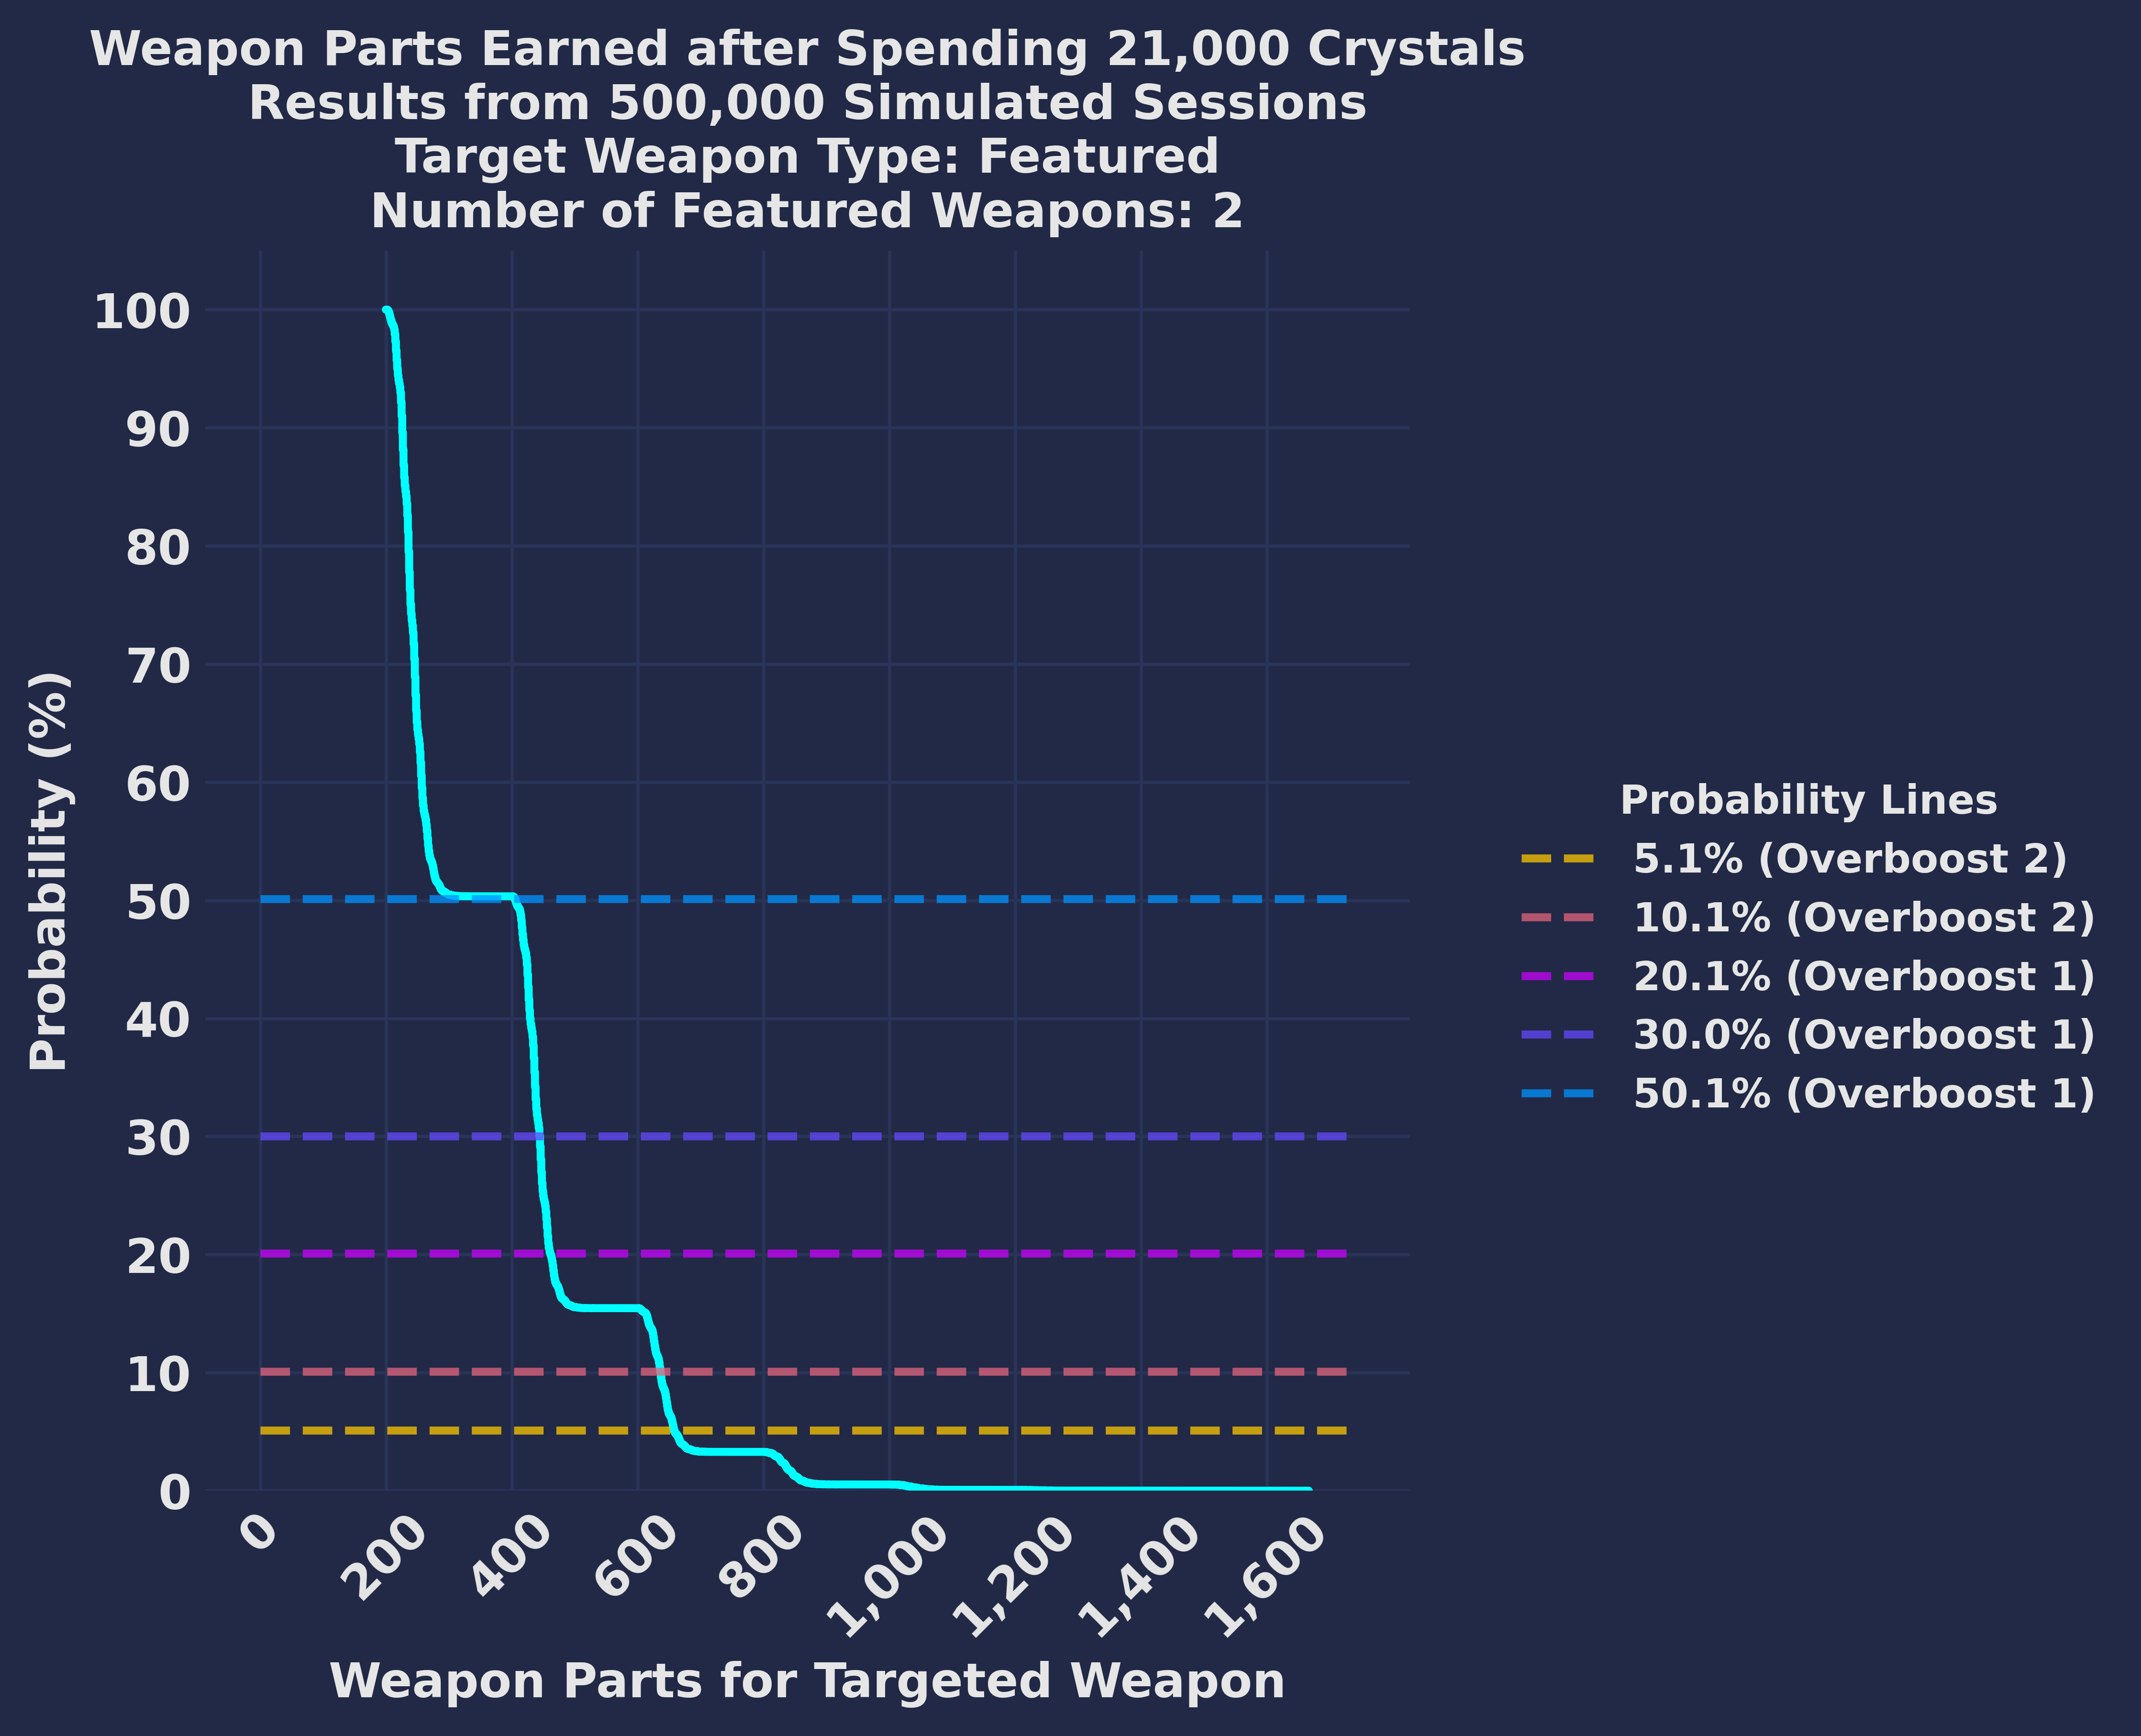

In [10]:
viz_wrapper(gs=gs1, column='targeted_weapon_parts', probs=[50, 70, 80, 90, 95])

This visualization shows us that we have about a 50% chance of reaching ~400 weapon parts, which translates to overboost 1. We know this, because we can see that half of the simulated pull sessions had about 400 weapon parts or more.

On the higher end, we know we have about a 5% chance of reaching ~650 weapon parts, which translates to overboost 2. Only 5.1% of the simulated pull sessions reached this number of weapon parts.

# Question #2: If I want weapon `Y` at power level `Z`, how much currency will I likely have to spend?

We can use `GachaSim` to answer this question as well! Let's say that, after realizing that trying to reach Overboost 6 with only 21,000 crystals is a terrible idea, we want to know how much we really ***should*** save up to get what we want.

In [11]:
gs2 = GachaSim(
        session_criterion="overboost",  # This time, the stopping criterion is the weapon's overboost level, instead of crystals spent
        criterion_value=6,  # We're saying, "spend as many crystals as you need to reach overboost 6, and then stop once you reach it"
        target_weapon_type="featured",  # This means we are targeting the fancy new weapon with increased rates. 
        banner_info=AERITH_LUCIA_EASTER_BANNER,  # We're selecting a random pull session location for this example
        seed_value=1337,  # For reproducibility, of course
        num_simulations=500_000,  # We will simulate 500,000 pull sessions
    )

In [12]:
gs2.run_sims(n_jobs=-1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [11:57<00:00, 696.52it/s]


In [13]:
gs2.sim_results.head(10)

,targeted_weapon_parts,total_stamps_earned,num_crystals_spent,targeted_five_stars_drawn,targeted_four_stars_drawn,targeted_three_stars_drawn,nontargeted_featured_five_stars_drawn,nontargeted_featured_four_stars_drawn,nontargeted_featured_three_stars_drawn,nontargeted_five_stars_drawn,nontargeted_four_stars_drawn,nontargeted_three_stars_drawn
0,1427,77,114000,6,19,37,5,24,41,20,49,179
1,1497,72,126000,6,26,37,4,17,38,28,52,212
2,1410,84,150000,5,37,40,3,24,46,26,64,255
3,1510,81,117000,6,27,40,4,24,36,25,58,170
4,1576,63,114000,7,14,36,4,12,29,29,42,207
5,1508,38,54000,7,9,18,3,7,19,7,28,82
6,1565,121,189000,6,30,65,5,32,58,44,86,304
7,1516,66,120000,6,26,56,5,17,37,23,41,189
8,1408,140,225000,5,32,88,14,36,76,44,98,357
9,1401,63,99000,6,17,31,4,13,25,20,57,157


This time, we see that `num_crystals_spent` isn't the same value throughout the dataframe, which is expected. We also see that it's ***way*** larger than 21,000 crystals in these examples! We're still only taking a look at 10 simulations, so let's summarize using the whole dataframe.

We could calculate summary statistics for `num_crystals_spent` if we really wanted to. However, this walkthrough is getting a bit long, so let's just jump ahead to visualization. 

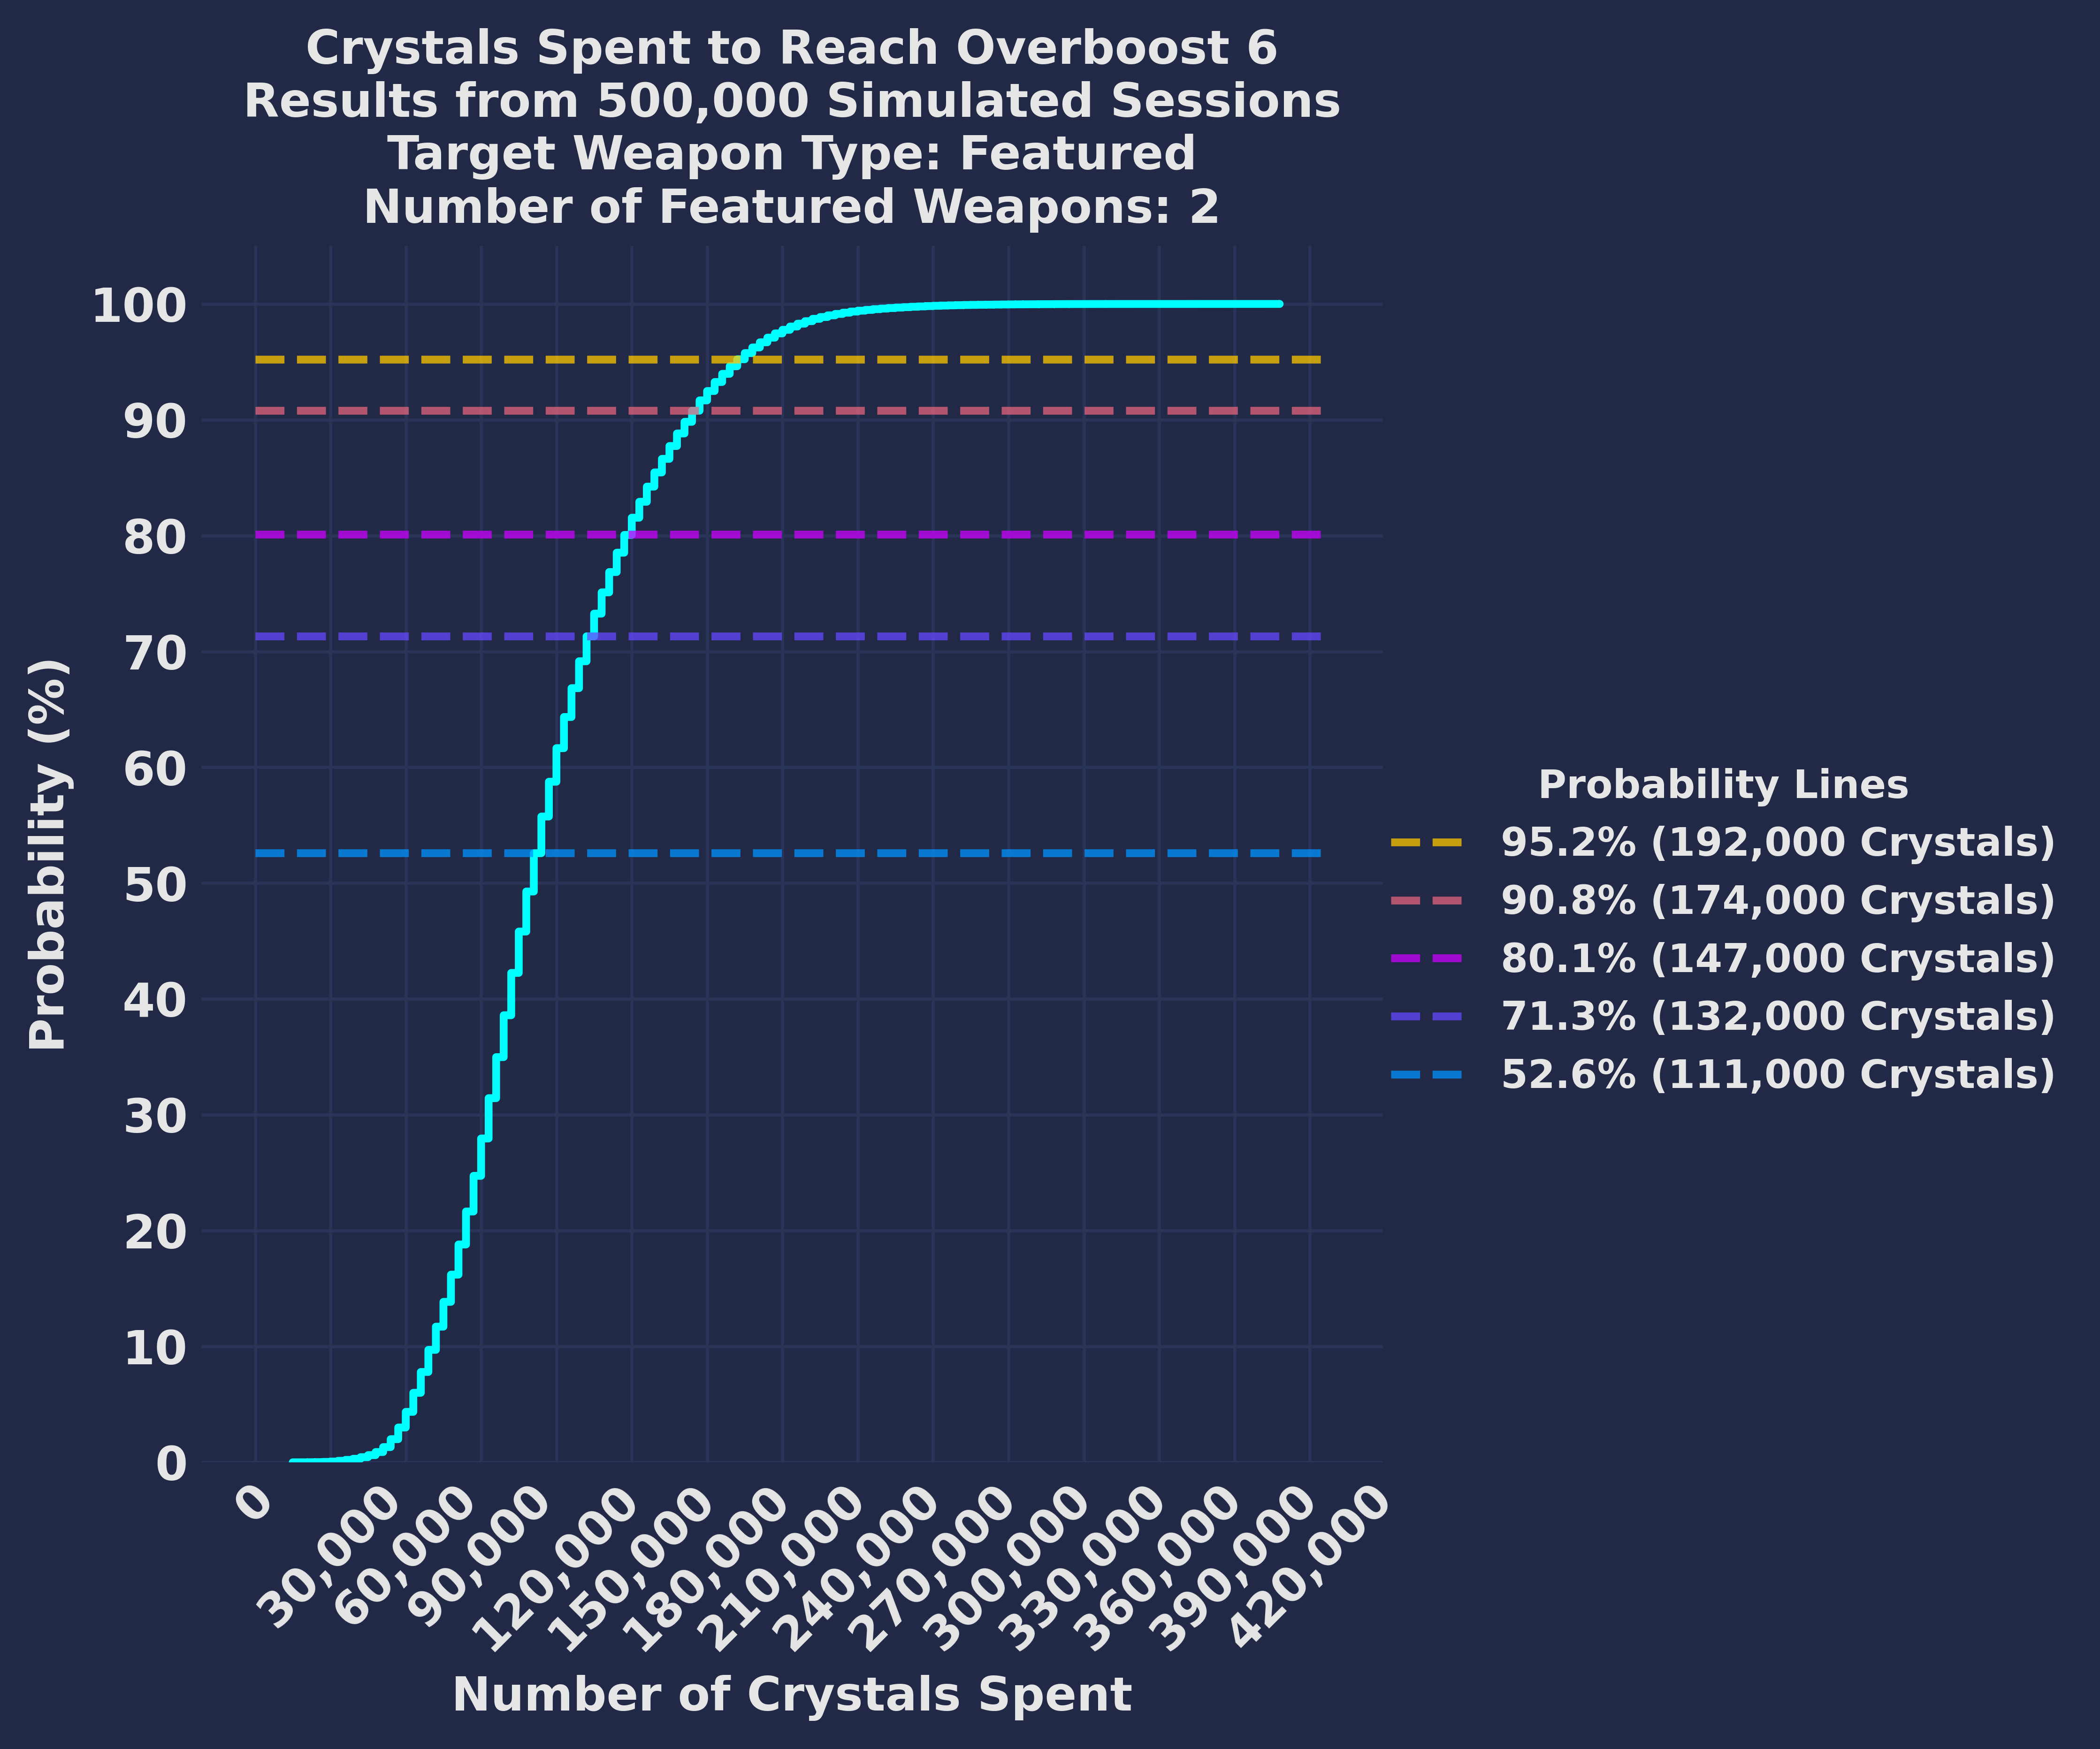

In [14]:
viz_wrapper(gs=gs2, column='num_crystals_spent', probs=[50, 70, 80, 90, 95])

Reading this visualization, we can see that, for an 80.1% chance of reaching Overboost 6, we need a mindblowing ***147,000 crystals!*** Even at 111,000 crystals, we're basically taking a 50-50 shot at what we want. Given that it takes ***months*** to save up that amount of currency -- especially if you're as reluctant to open your wallet for these kinds of games as I am -- I'd say 50-50 is way too much risk! I'll wait and save, thank you very much. 

# Summary

Let's recap:

1. Understanding the likelihood of different outcomes in a Gacha game is difficult, as companies that make these types of games don't answer the real questions we have and just want us to spend.
2. `GachaSim` allows us to take the information they're legally required to share and extrapolate on it via Monte Carlo simulation.
3. We can then analyze the data from these simulations to answer questions, such as:
   a. "If I spend `X` amount of currency, how much of weapon `Y` am I likely to get?"
   b. "If I want weapon `Y` at power level `Z`, how much currency will I likely have to spend?"
4. We walked through examples of using `GachaSim` to answer these questions and improve our decision making about how to (not) use our currency.

Thank you for taking the time to read through this walkthrough of my project! Please don't hesitate to leave feedback, and if you liked it, be sure to keep an eye out for future updates! 